In [1]:
#import
import os
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
def GetAnglefromEta(fEta = 0.1):
    fTheta = 2*np.arctan(np.exp(-fEta))
    return fTheta

#function test
print(GetAnglefromEta(fEta = 0.88))

0.7863699077786936


In [3]:
#print("\U0001F9E0")  # 🧠
#print("\u2705")       # ✅
#print("\u274C")       # ❌
#print("\u26A0")       # ⚠️


fSAVE = False

def GetResultData(fAngle, fMom, fSetting):
    base_path = '/Users/tua88437/Dropbox/EIC/EPIC/Simulation/PID_AngularResolutions/Craterlake/25.07.0/results/DIRCScan/'
    base_path = base_path + fSetting + '/dat/'
    res = base_path + fAngle + 'Res/Seed/MomBin/MomVector/' + fAngle + 'Res_Seed_MomBin_' + fMom + 'GeV.dat'
    eta, sigma, eta_err, sigma_err = np.loadtxt(res, unpack=True)
    return eta, sigma, eta_err, sigma_err

# Arrays
#Full Settings available
#settings = [
#    'tracking_only','tracking_only_10umBOT','tracking_only_50umBOT',
#    'tracking_only_70umBOT','tracking_only_85umBOT','tracking_only_100umBOT',
#    'tracking_only_250umBOT','tracking_only_noBOTHits','tracking_only_noBOT'
#]
#Selected settings
settings = [
    'tracking_only','tracking_only_10umBOT','tracking_only_70umBOT','tracking_only_85umBOT','tracking_only_100umBOT','tracking_only_noBOT'
]

angles = ['Theta', 'Phi']
moms = ['1.00','2.00','4.00','6.00','8.00','10.00','12.00']

# Store all results here
rows = []

for setting in settings:
    for angle in angles:
        for mom in moms:
            try:
                eta, sigma, eta_err, sigma_err = GetResultData(angle, mom, setting)
                for e, s, de, ds in zip(eta, sigma, eta_err, sigma_err):
                    rows.append({
                        "setting": setting,
                        "angle": angle,
                        "momentum_GeV": float(mom),
                        "eta": e,
                        "sigma": s,
                        "eta_err": de,
                        "sigma_err": ds
                    })
                print(f"Loaded: {setting}, {angle}, {mom} GeV ({len(eta)} points)")
            except FileNotFoundError:
                print(f"❌ File not found for {setting}, {angle}, {mom}")
            except Exception as e:
                print(f"⚠️ Error loading {setting}, {angle}, {mom}: {e}")

# Convert list of dicts → DataFrame
df = pd.DataFrame(rows)

print("\n✅ DataFrame built successfully!")
print(df.head())


Loaded: tracking_only, Theta, 1.00 GeV (75 points)
Loaded: tracking_only, Theta, 2.00 GeV (75 points)
Loaded: tracking_only, Theta, 4.00 GeV (75 points)
Loaded: tracking_only, Theta, 6.00 GeV (75 points)
Loaded: tracking_only, Theta, 8.00 GeV (75 points)
Loaded: tracking_only, Theta, 10.00 GeV (75 points)
Loaded: tracking_only, Theta, 12.00 GeV (75 points)
Loaded: tracking_only, Phi, 1.00 GeV (75 points)
Loaded: tracking_only, Phi, 2.00 GeV (75 points)
Loaded: tracking_only, Phi, 4.00 GeV (75 points)
Loaded: tracking_only, Phi, 6.00 GeV (75 points)
Loaded: tracking_only, Phi, 8.00 GeV (75 points)
Loaded: tracking_only, Phi, 10.00 GeV (75 points)
Loaded: tracking_only, Phi, 12.00 GeV (75 points)
Loaded: tracking_only_10umBOT, Theta, 1.00 GeV (75 points)
Loaded: tracking_only_10umBOT, Theta, 2.00 GeV (75 points)
Loaded: tracking_only_10umBOT, Theta, 4.00 GeV (75 points)
Loaded: tracking_only_10umBOT, Theta, 6.00 GeV (75 points)
Loaded: tracking_only_10umBOT, Theta, 8.00 GeV (75 points)
L

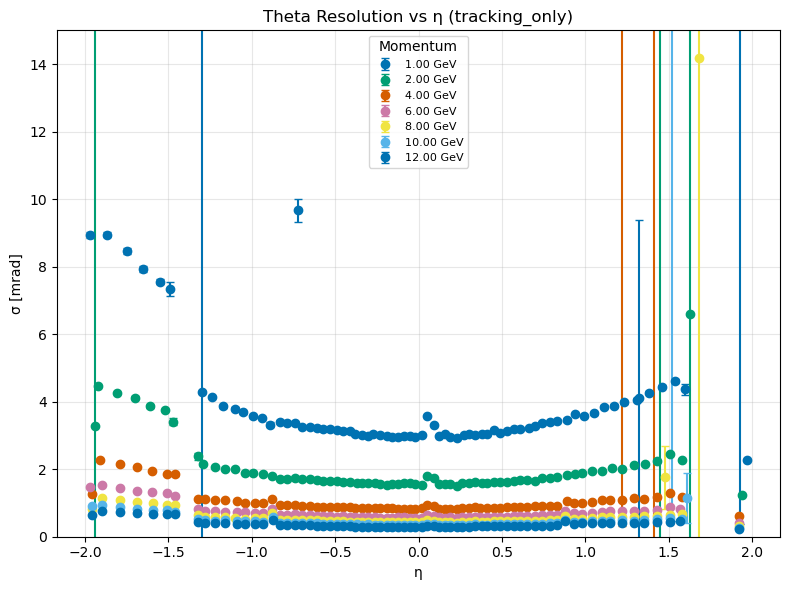

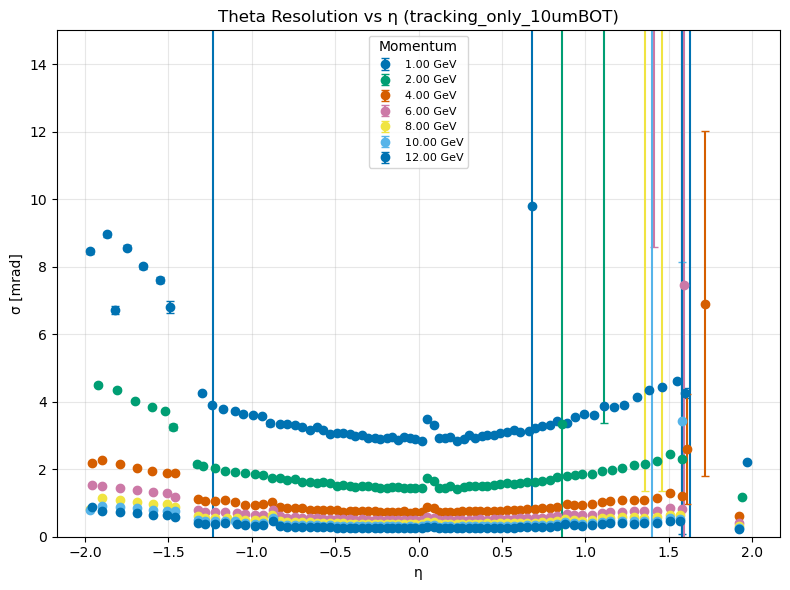

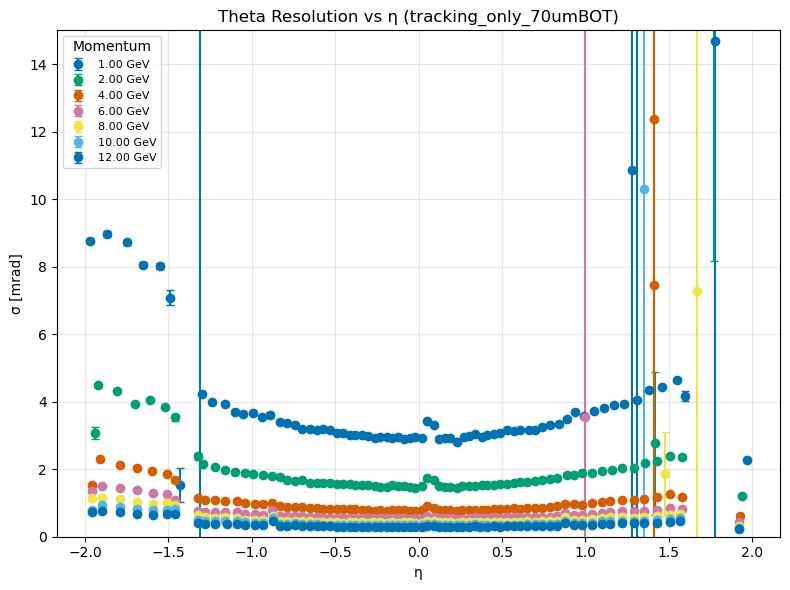

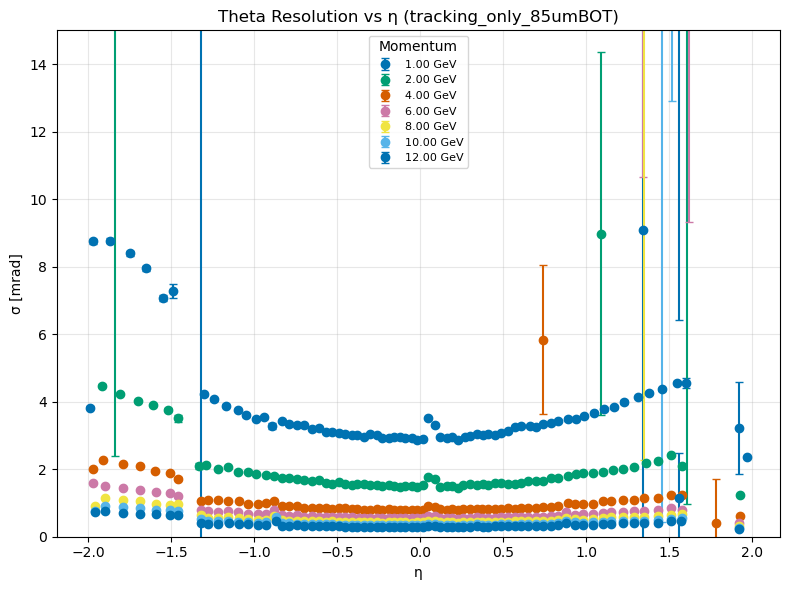

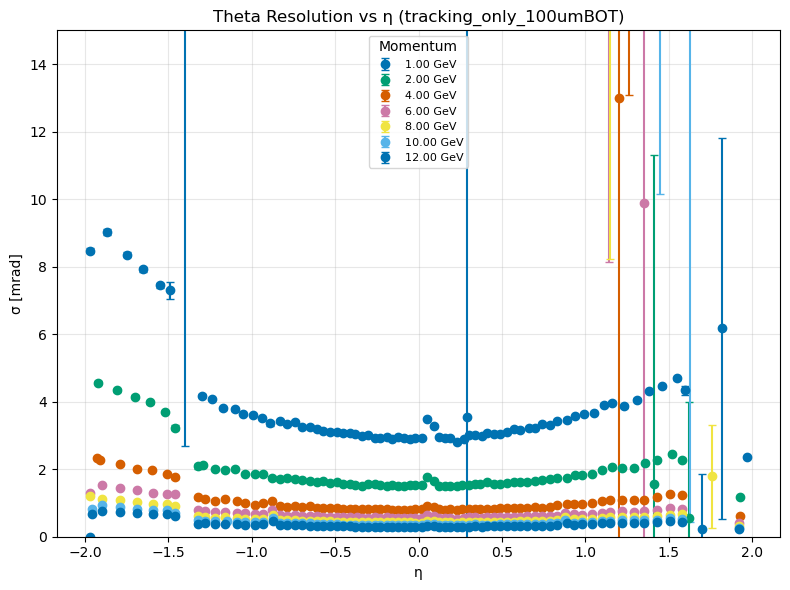

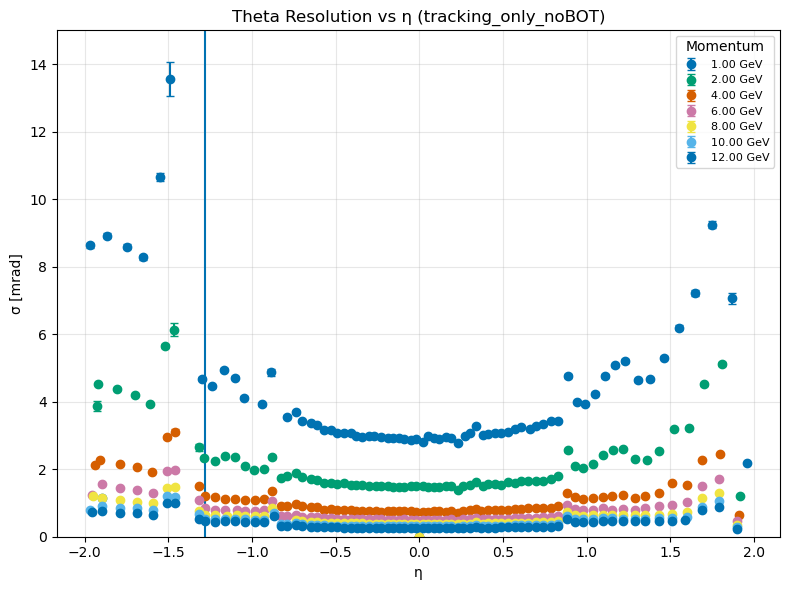

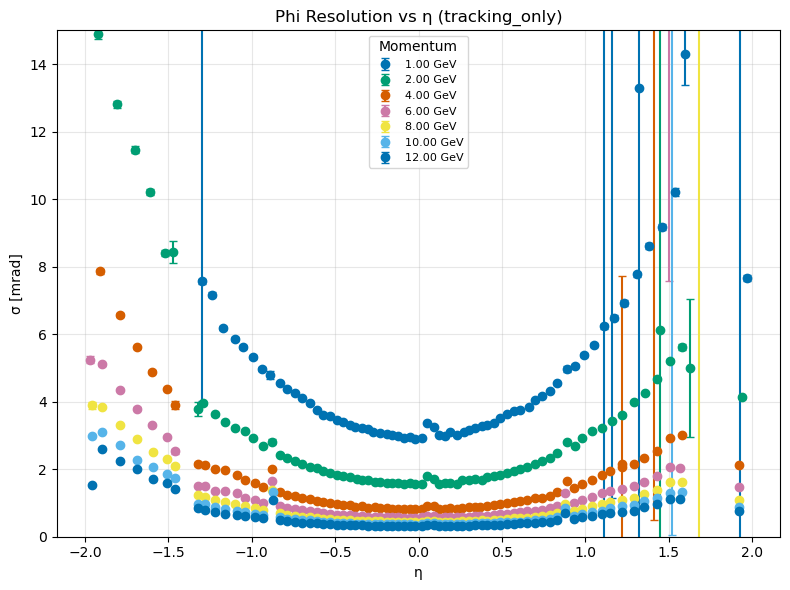

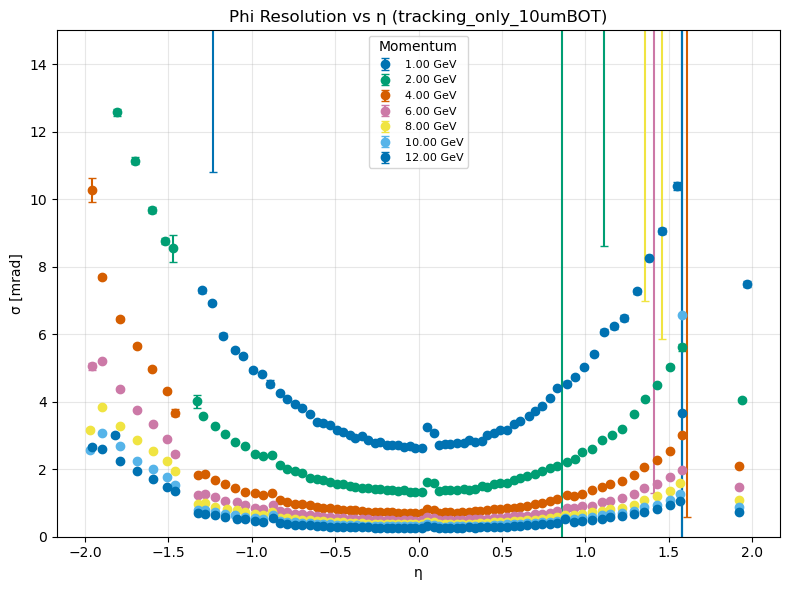

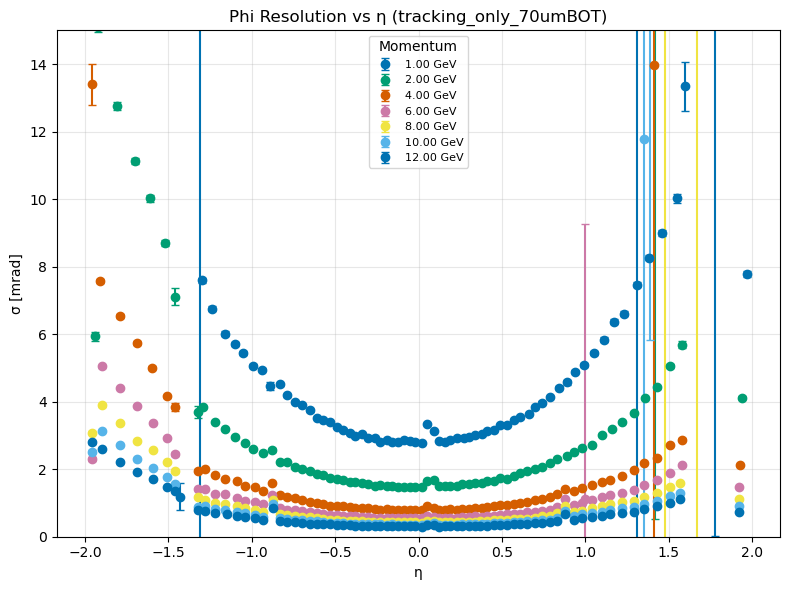

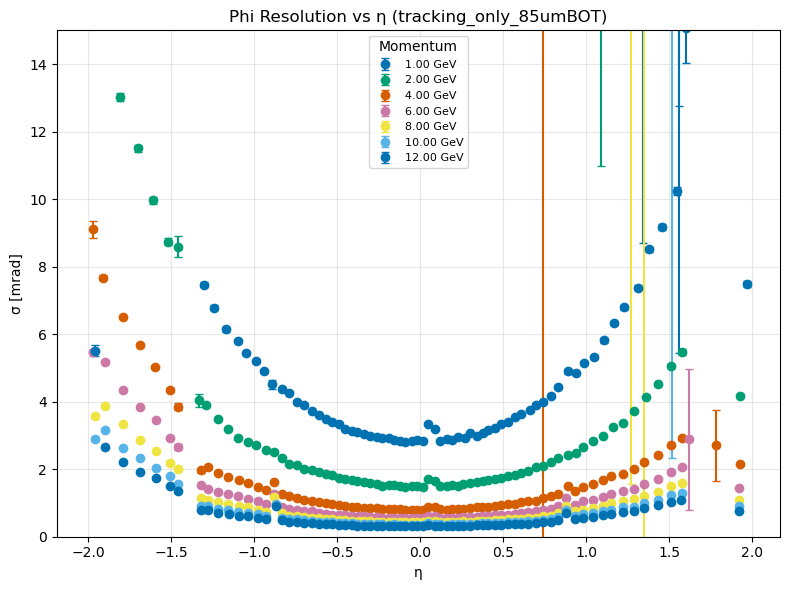

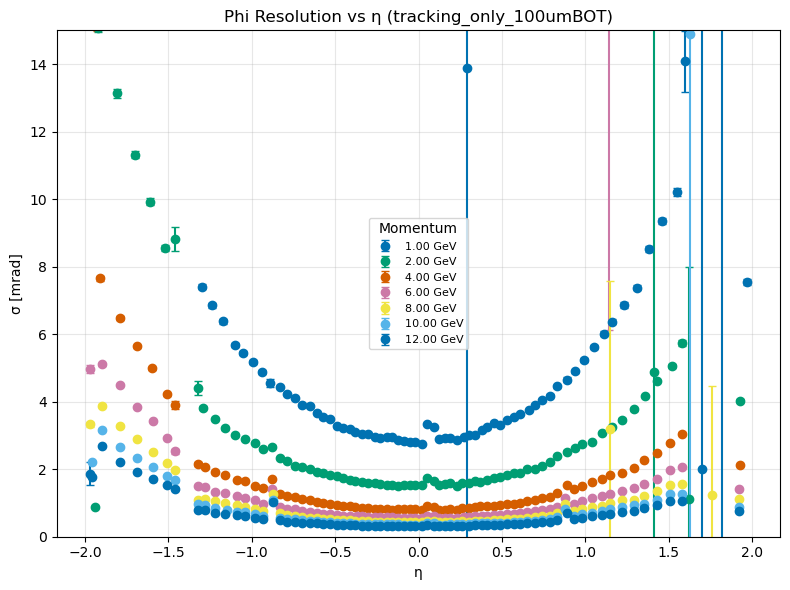

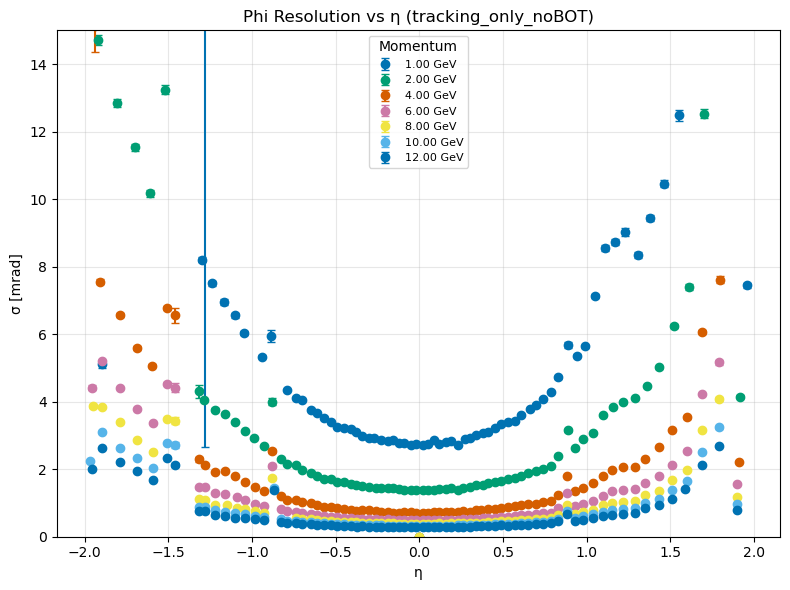

In [4]:
plt.style.use("seaborn-v0_8-colorblind")  # nice default style

output_pdf = "AllSettings_Angles_SigmaVsEta.pdf"

with PdfPages(output_pdf) as pdf:  # open PDF to save multiple pages

    for angle in angles:
        for setting in settings:
            subset = df[(df['angle'] == angle) & (df['setting'] == setting)]
            if subset.empty:
                continue

            plt.figure(figsize=(8, 6))

            for mom in sorted(subset['momentum_GeV'].unique()):
                mom_subset = subset[subset['momentum_GeV'] == mom]
                plt.errorbar(
                    mom_subset['eta'], mom_subset['sigma'],
                    yerr=mom_subset['sigma_err'],
                    fmt='o', label=f'{mom:.2f} GeV', capsize=3
                )

            plt.title(f'{angle} Resolution vs η ({setting})')
            plt.xlabel('η')
            plt.ylabel('σ [mrad]')
            plt.ylim(0,15)
            plt.legend(title="Momentum", fontsize=8)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            
            if (fSAVE == True):
              pdf.savefig()   # save current figure as a page in the PDF
              plt.close()     # close figure to free memory
              print(f"✅ Saved all figures into {output_pdf}")

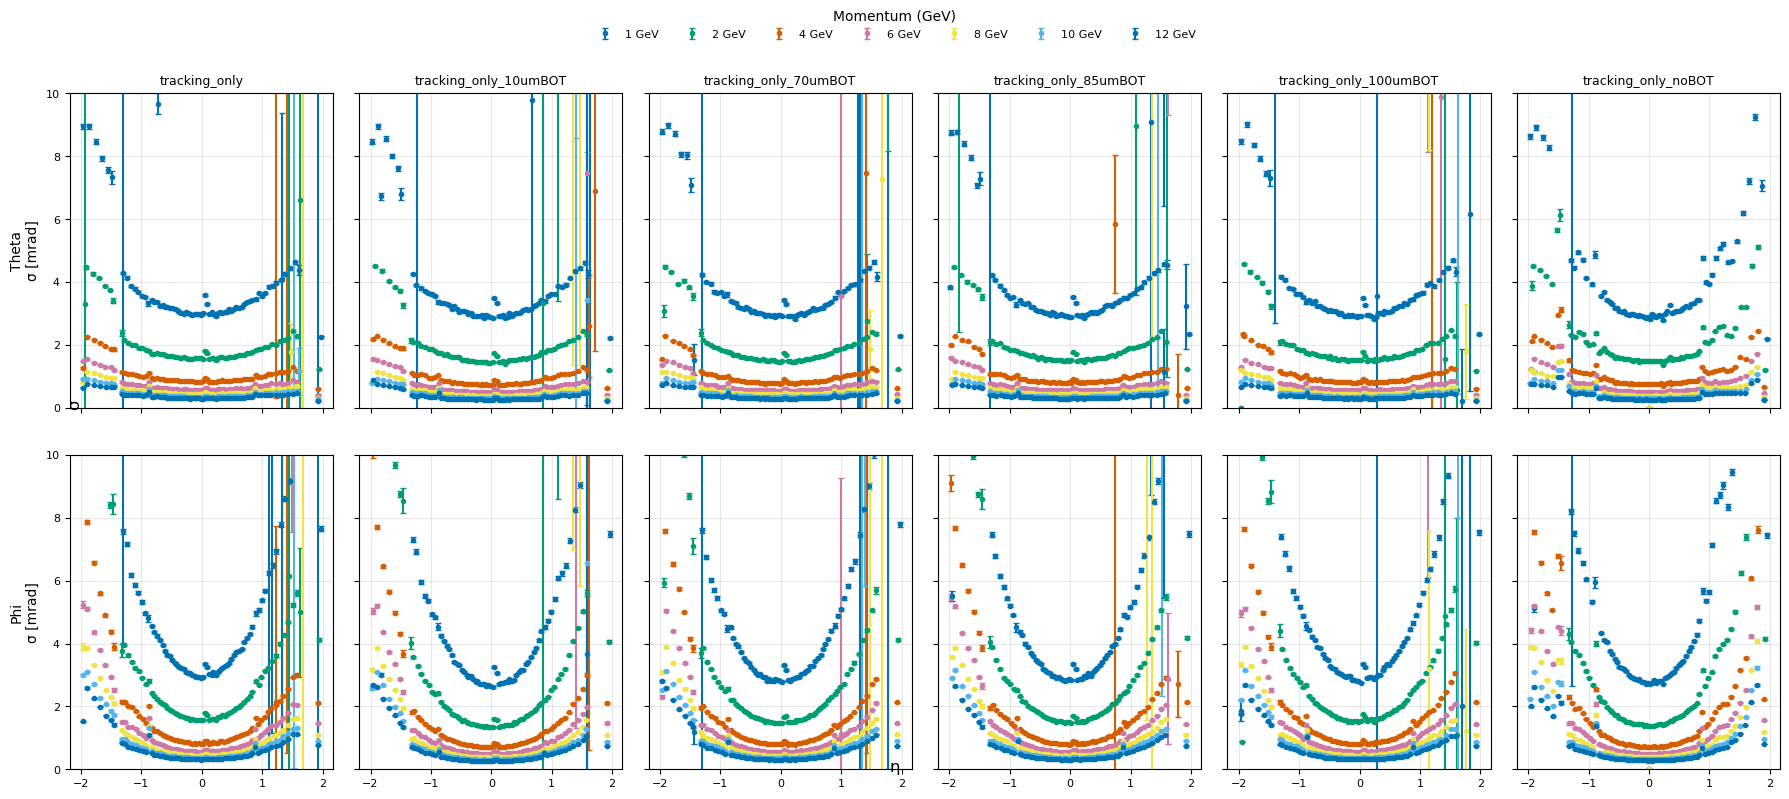

In [5]:
# --- Multi-panel plot setup ---
plt.style.use("seaborn-v0_8-colorblind")

nrows = len(angles)
ncols = len(settings)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 4*nrows), sharex=True, sharey=True)

# If there's only one angle or setting, make sure axes is 2D
axes = np.atleast_2d(axes)

# --- Loop through angles (rows) and settings (columns) ---
for i, angle in enumerate(angles):
    for j, setting in enumerate(settings):
        ax = axes[i, j]
        subset = df[(df['angle'] == angle) & (df['setting'] == setting)]
        if subset.empty:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=8, color='red')
            ax.set_axis_off()
            continue

        for mom in sorted(subset['momentum_GeV'].unique()):
            mom_subset = subset[subset['momentum_GeV'] == mom]
            ax.errorbar(
                mom_subset['eta'], mom_subset['sigma'],
                yerr=mom_subset['sigma_err'],
                fmt='o', label=f'{mom:.0f} GeV', capsize=2, markersize=3
            )
        # Set y-axis limits
        ax.set_ylim(0, 10)
        
        if i == 0:
            ax.set_title(setting, fontsize=9)
        if j == 0:
            ax.set_ylabel(f'{angle}\nσ [mrad]', fontsize=10)

        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=8)

# --- Shared axis labels ---
fig.text(0.5, 0.04, 'η', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'σ', va='center', rotation='vertical', fontsize=12)

# --- Common legend ---
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Momentum (GeV)", loc='upper center', ncol=len(moms), fontsize=8, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.subplots_adjust(wspace=0.1, hspace=0.15)

if(fSAVE == True):
   outname = "AllSettings_Angles_SigmaVsEta.png"
   plt.savefig(outname, dpi=200)
   plt.close()
   print(f"🖼️ Saved combined plot as: {outname}")

/var/folders/rs/hfbcnwdx1qlgqx6rh363b8vn361sdk/T/ipykernel_47528/1690950252.py:45: RuntimeWarning: invalid value encountered in divide
  (subset['sigma_err'].values / subset['sigma'].values)**2 +


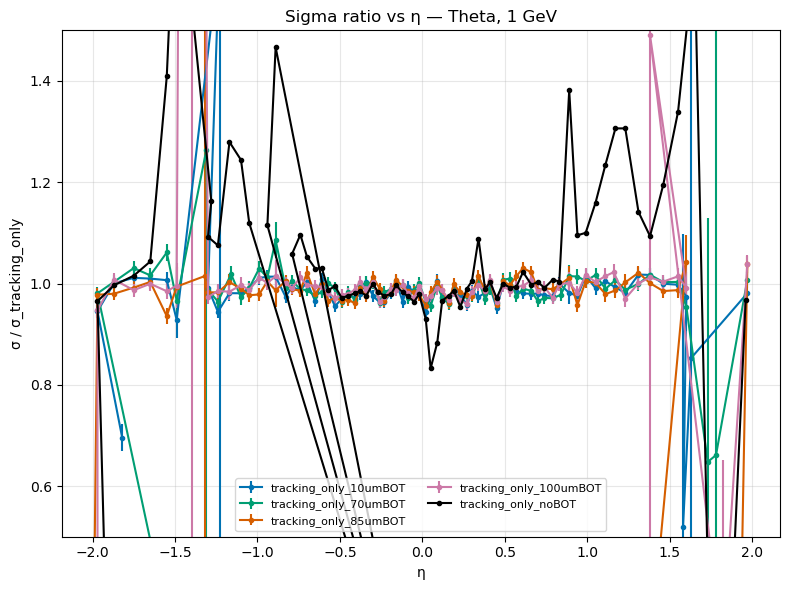

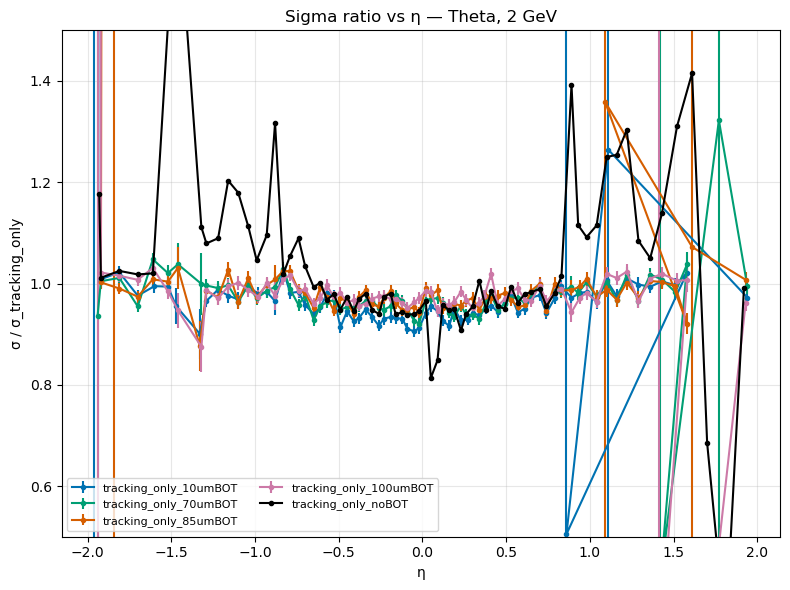

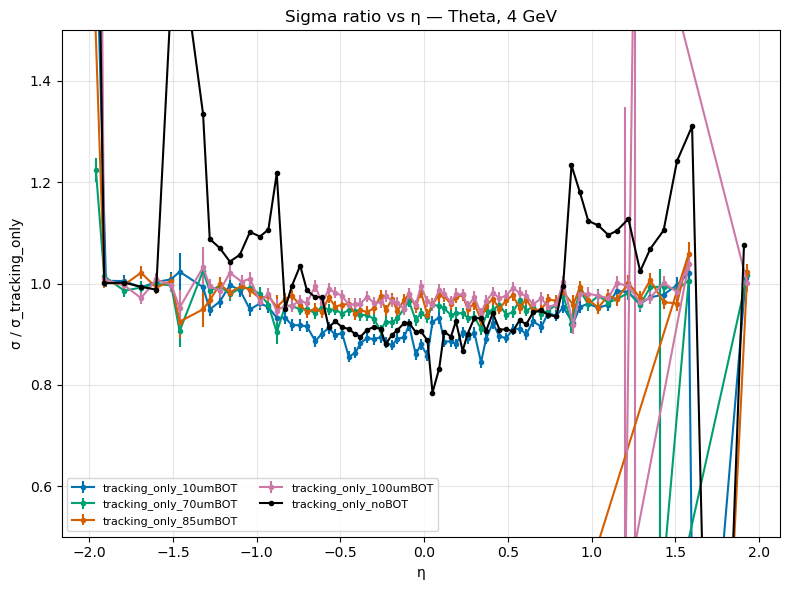

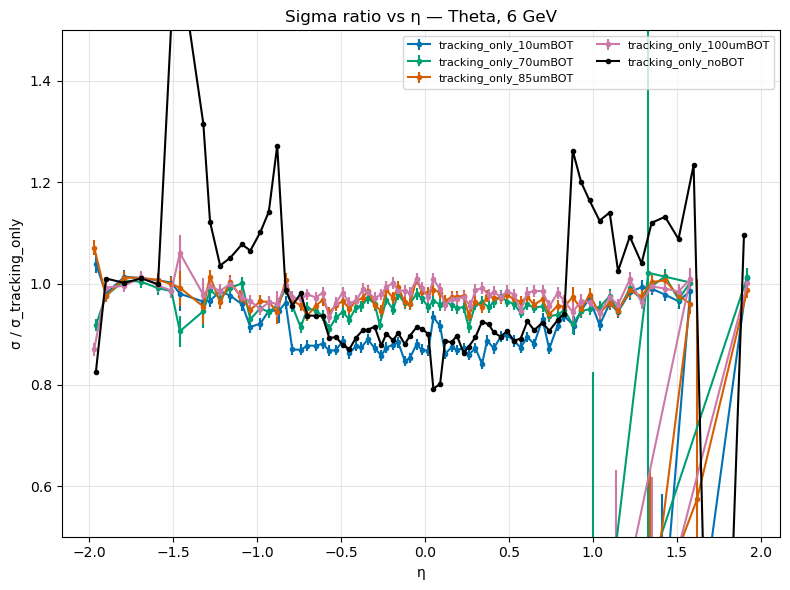

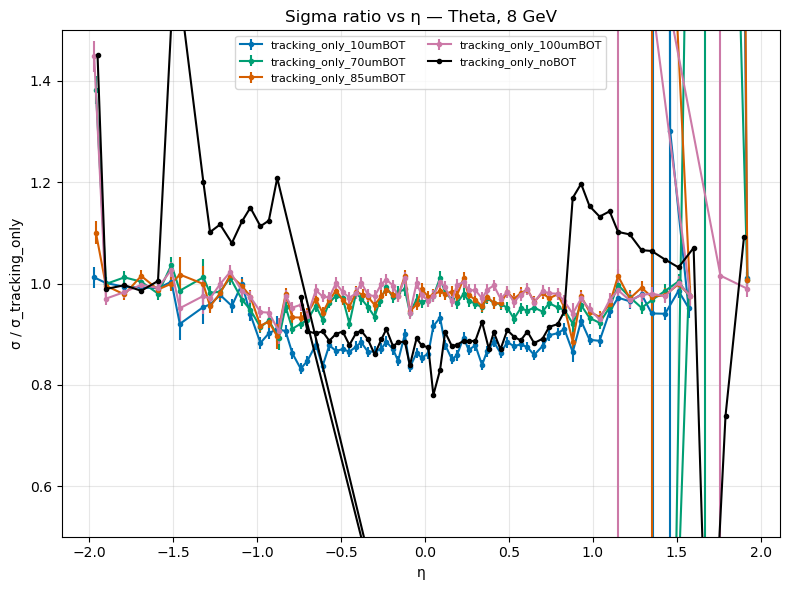

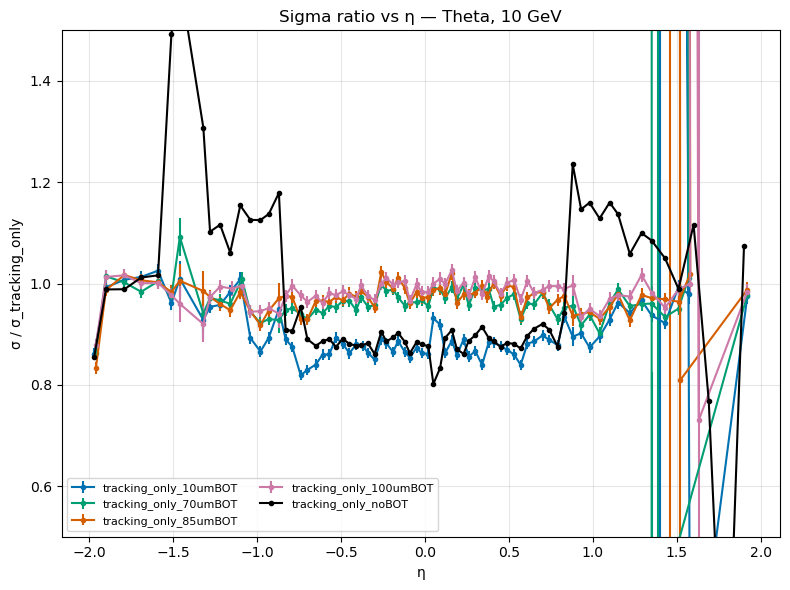

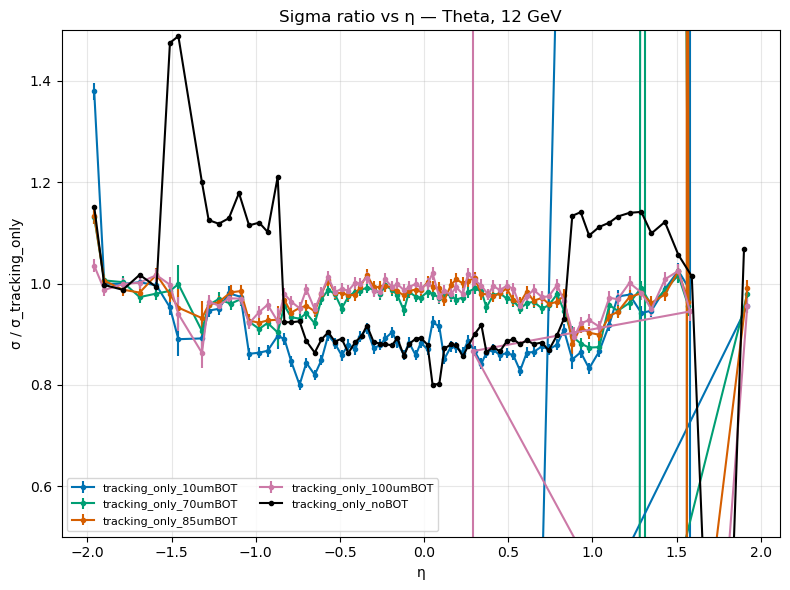

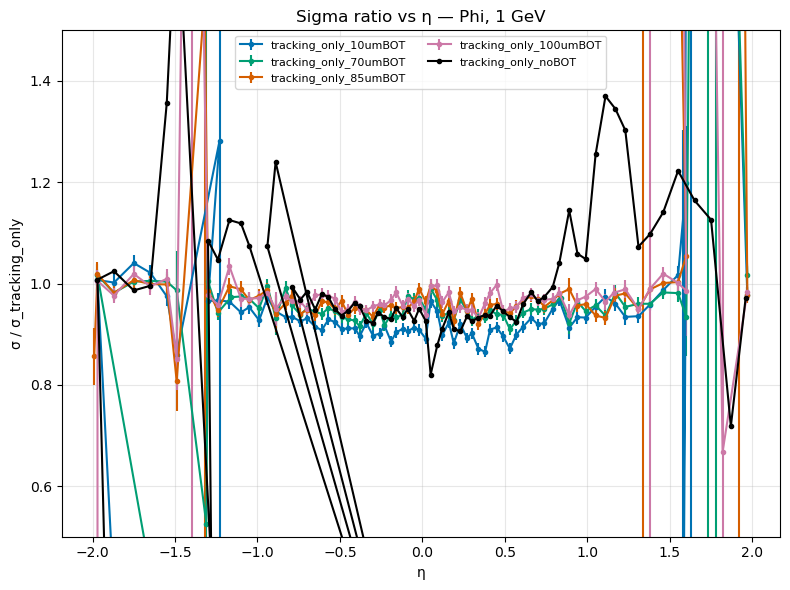

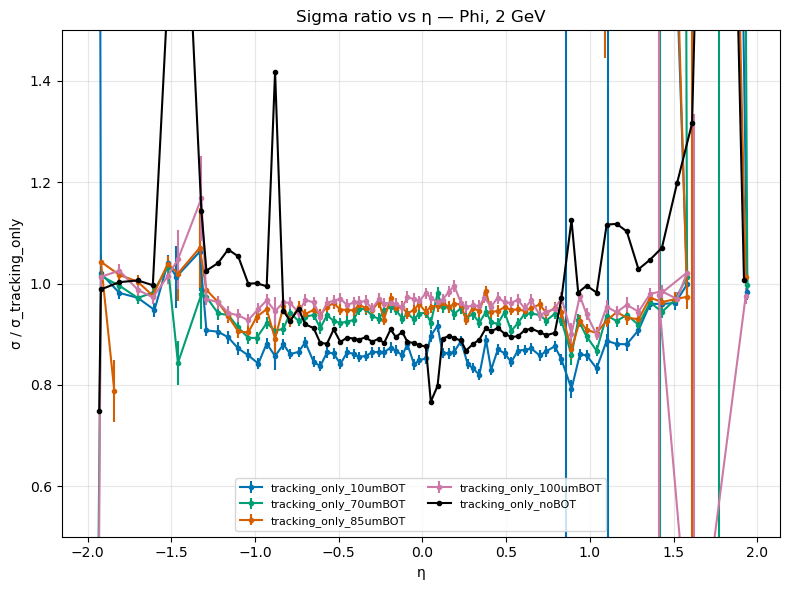

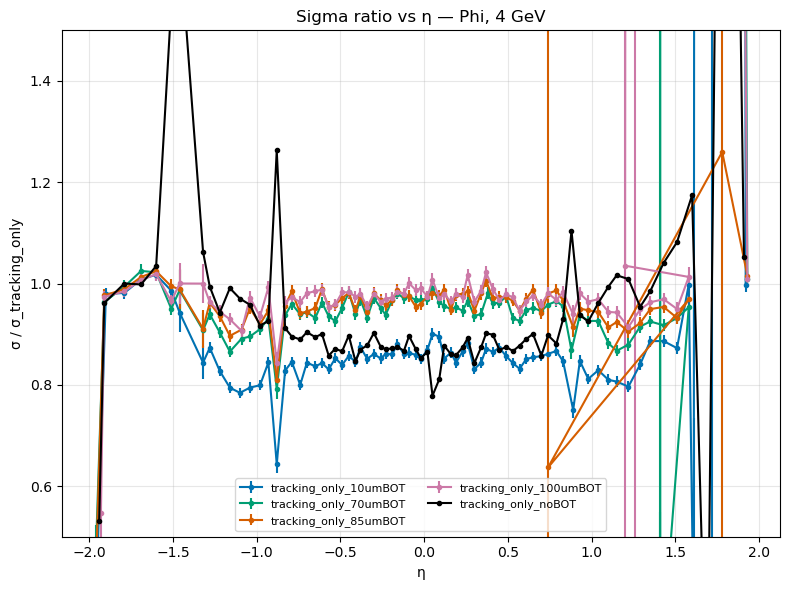

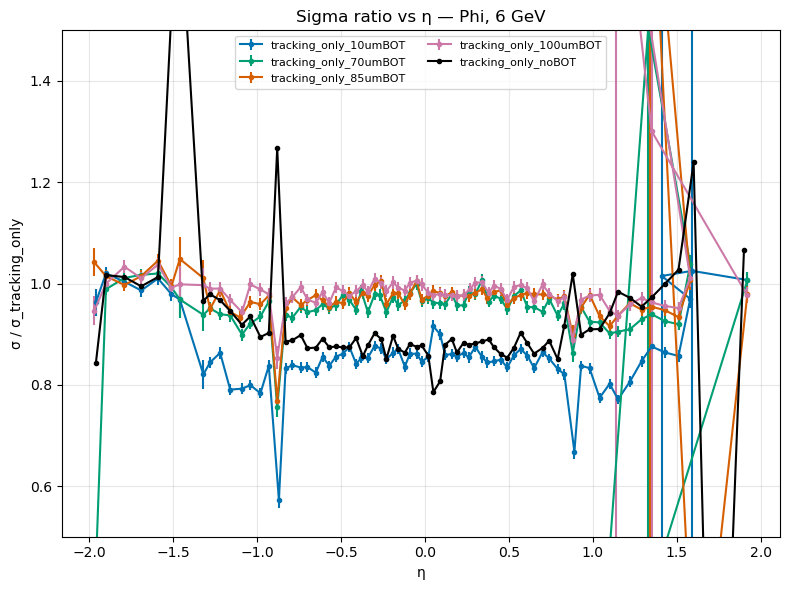

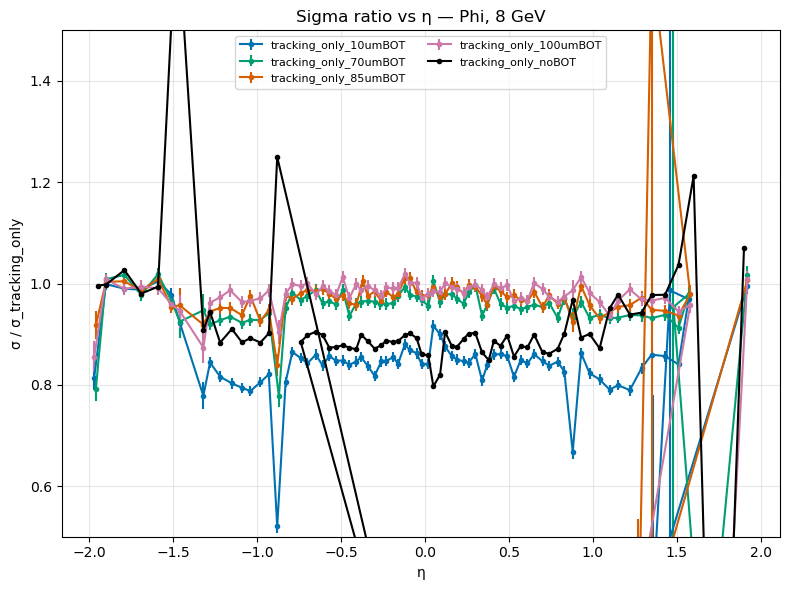

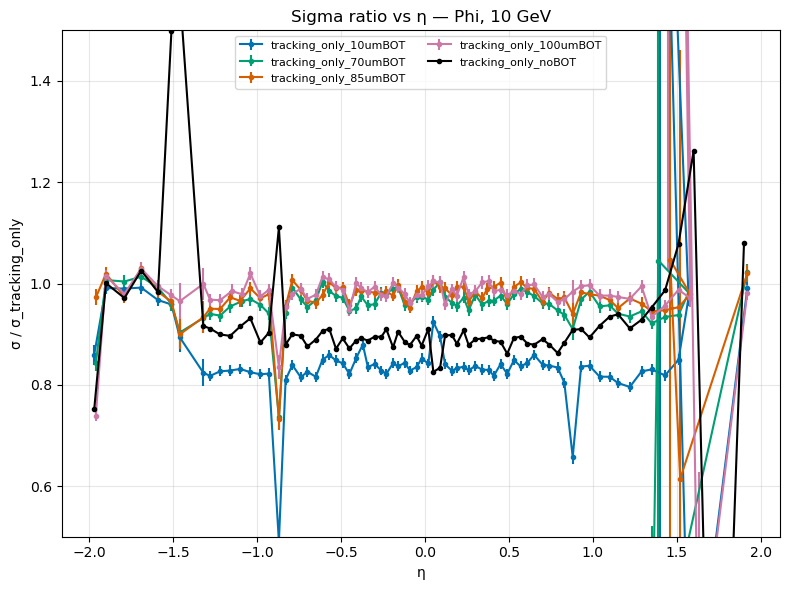

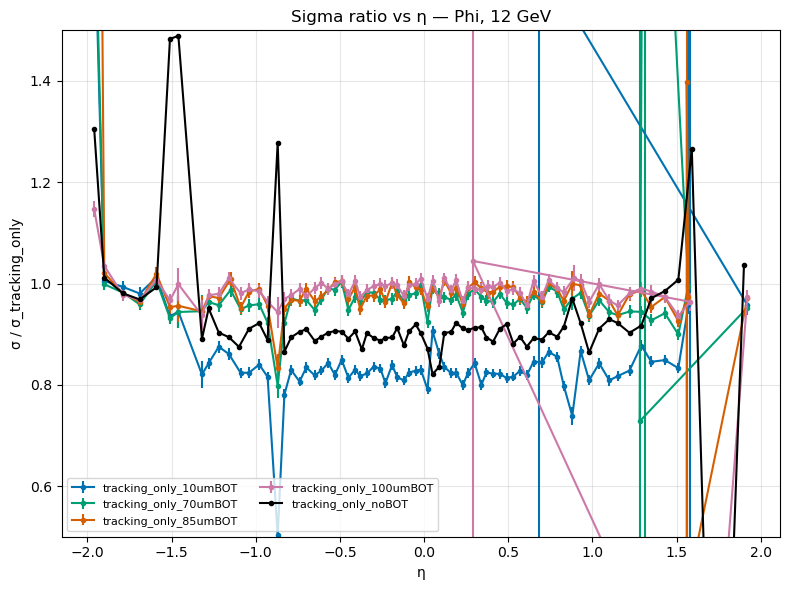

In [71]:
#full settings 
#settings_to_compare = [
#    'tracking_only_10umBOT','tracking_only_50umBOT',
#    'tracking_only_70umBOT','tracking_only_85umBOT',
#    'tracking_only_100umBOT','tracking_only_250umBOT',
#    'tracking_only_noBOTHits','tracking_only_noBOT'
#]
#selected settings
settings_to_compare = [
    'tracking_only_10umBOT','tracking_only_70umBOT','tracking_only_85umBOT',
    'tracking_only_100umBOT','tracking_only_noBOT'
]

baseline_setting = 'tracking_only'
angles = ['Theta', 'Phi']
moms = sorted(df['momentum_GeV'].unique())

plt.style.use("seaborn-v0_8-colorblind")

# --- Loop over angles to create separate PDFs ---
for angle in angles:
    output_pdf = f"SigmaRatios_{angle}_AllMomenta.pdf"

    with PdfPages(output_pdf) as pdf:

        for mom in moms:
            plt.figure(figsize=(8,6))

            # Extract baseline for this angle and momentum
            baseline_df = df[(df['setting'] == baseline_setting) &
                             (df['angle'] == angle) &
                             (df['momentum_GeV'] == mom)]
            
            for setting in settings_to_compare:
                subset = df[(df['setting'] == setting) &
                            (df['angle'] == angle) &
                            (df['momentum_GeV'] == mom)]
               
                if len(baseline_df) != len(subset):
                    print(f"⚠️ Skipping {setting}, {angle}, {mom} GeV due to mismatched eta bins")
                    continue

                ratio = subset['sigma'].values / baseline_df['sigma'].values
                ratio_err = ratio * np.sqrt(
                    (subset['sigma_err'].values / subset['sigma'].values)**2 +
                    (baseline_df['sigma_err'].values / baseline_df['sigma'].values)**2
                )

                if  setting == 'tracking_only_noBOT':
                    plt.errorbar(
                        subset['eta'], ratio,
                        fmt='o-', c='black', markersize=3,
                        label=f"{setting}"
                    )
                else:
                    plt.errorbar(
                        subset['eta'], ratio,
                        yerr=ratio_err,
                        fmt='o-', markersize=3,
                        label=f"{setting}"
                    )

            plt.xlabel('η')
            plt.ylabel('σ / σ_tracking_only')
            plt.title(f"Sigma ratio vs η — {angle}, {mom:.0f} GeV")
            plt.ylim(0.5, 1.5)
            plt.grid(alpha=0.3)
            plt.legend(fontsize=8, ncol=2)
            plt.tight_layout()

            if(fSAVE == True):
               pdf.savefig()   # save current figure as a page in the PDF
               plt.close()     # close figure to free memory
               print(f"✅ Saved all {angle} momentum plots into {output_pdf}")


In [7]:
df.head(10)

setting  angle  momentum_GeV   eta     sigma  eta_err  sigma_err
0  tracking_only  Theta           1.0  1.97   2.26501      0.0    0.02601
1  tracking_only  Theta           1.0  1.93  22.20535      0.0   21.84179
2  tracking_only  Theta           1.0  1.11  71.83927      0.0   36.19353
3  tracking_only  Theta           1.0  1.60   4.36722      0.0    0.16112
4  tracking_only  Theta           1.0  1.54   4.62196      0.0    0.05540
5  tracking_only  Theta           1.0  1.46   4.43682      0.0    0.04321
6  tracking_only  Theta           1.0  1.38   4.26832      0.0    0.03813
7  tracking_only  Theta           1.0  1.31   4.05494      0.0    0.03948
8  tracking_only  Theta           1.0  1.23   3.98080      0.0    0.04903
9  tracking_only  Theta           1.0  1.17   3.88274      0.0    0.04253

No match found
No BOT
No match found
No BOT
No match found
No BOT
No match found
No BOT
No match found
No BOT
No match found
No BOT
No match found
No BOT
No match found
No BOT
No match found
No BOT
No match found
No BOT
No match found
No BOT
No match found
No BOT
No match found
No BOT
No match found
No BOT


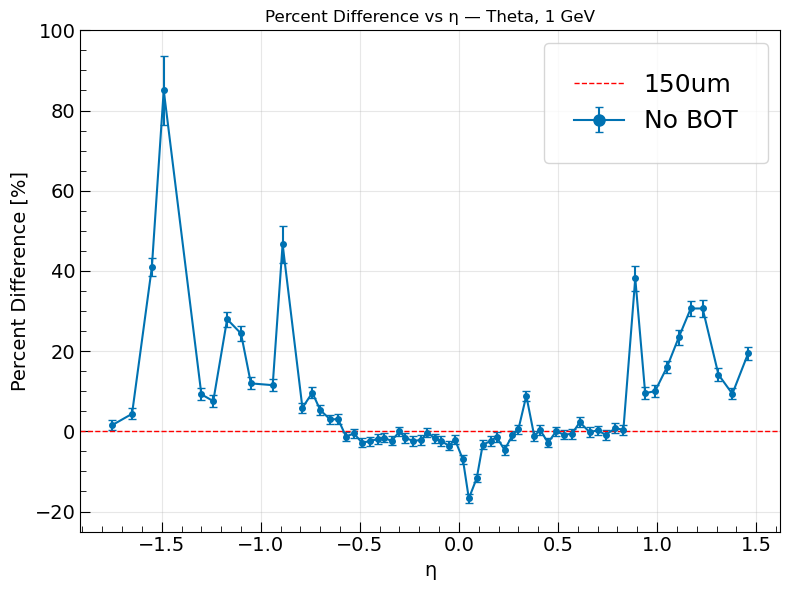

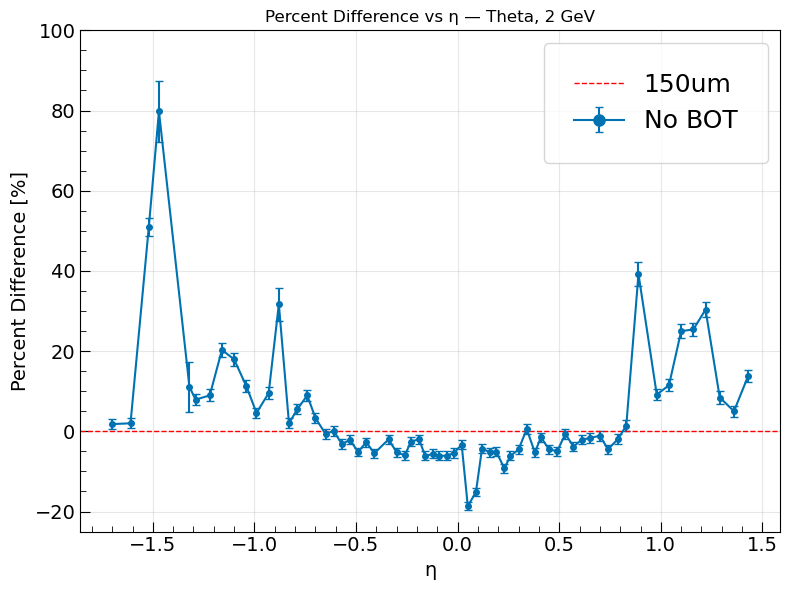

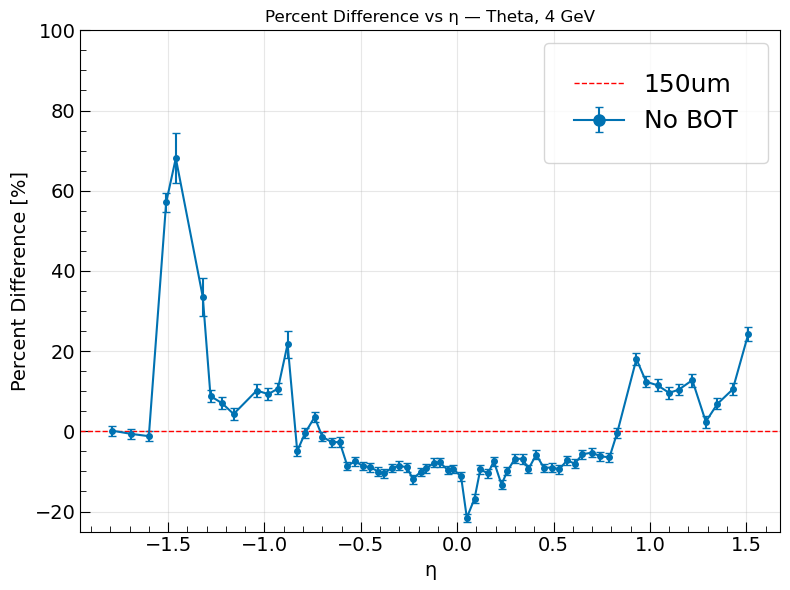

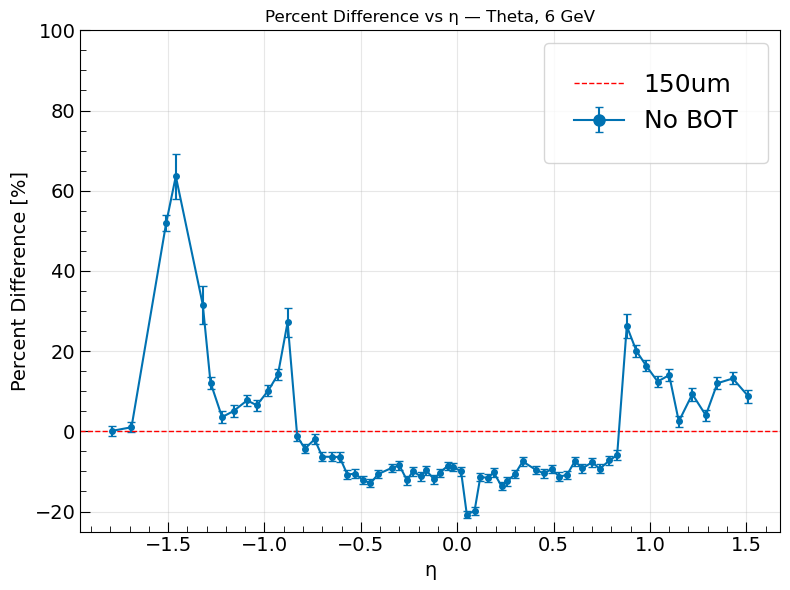

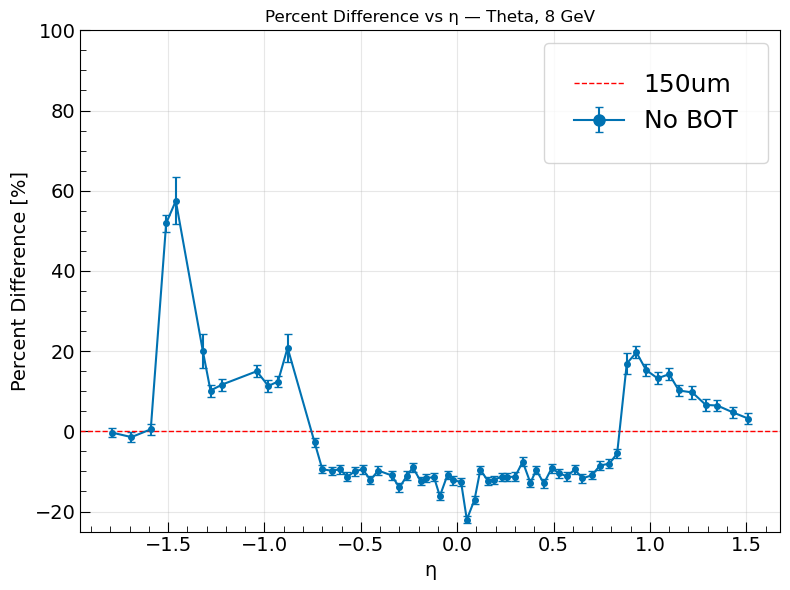

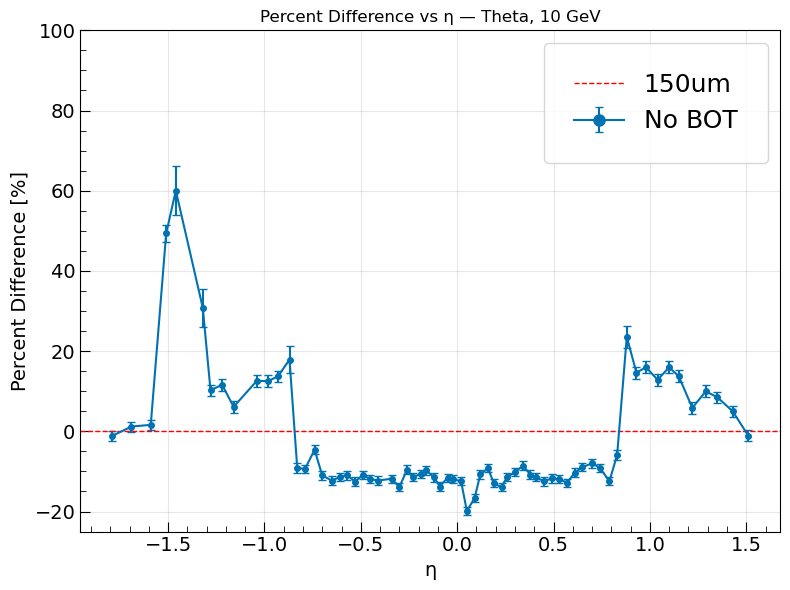

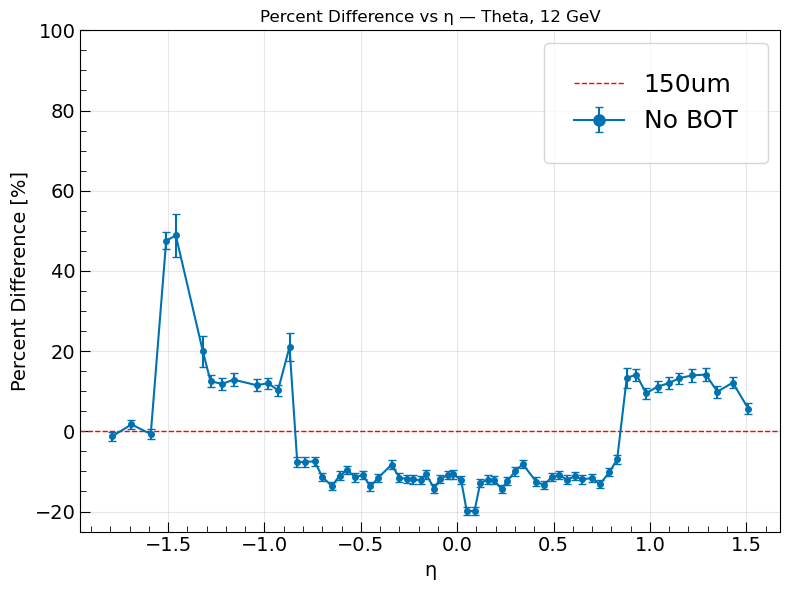

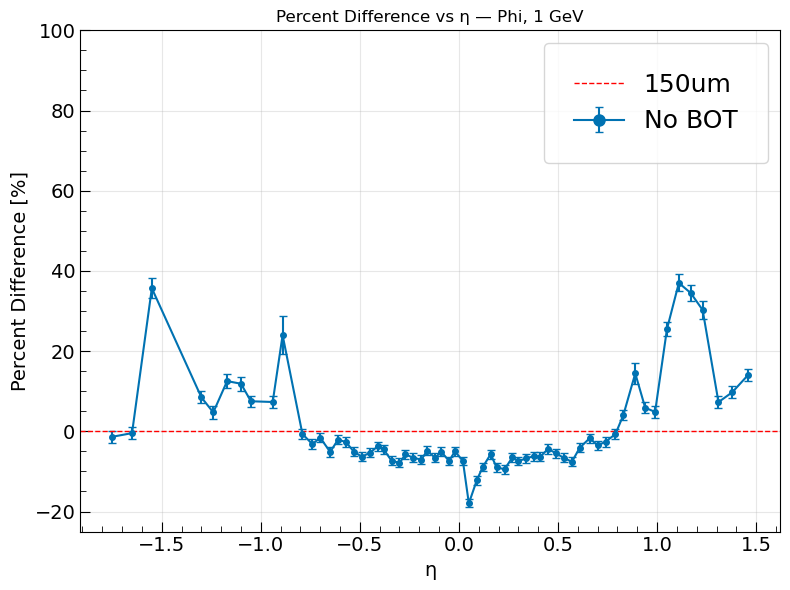

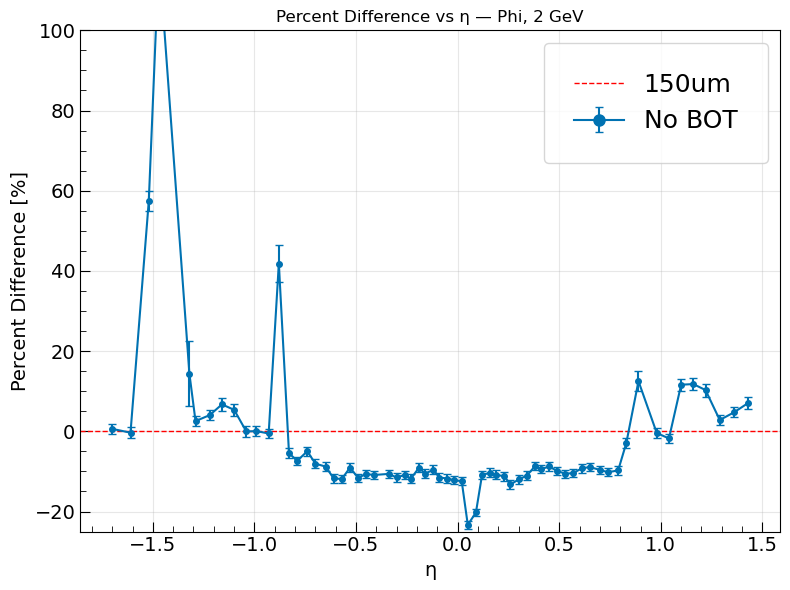

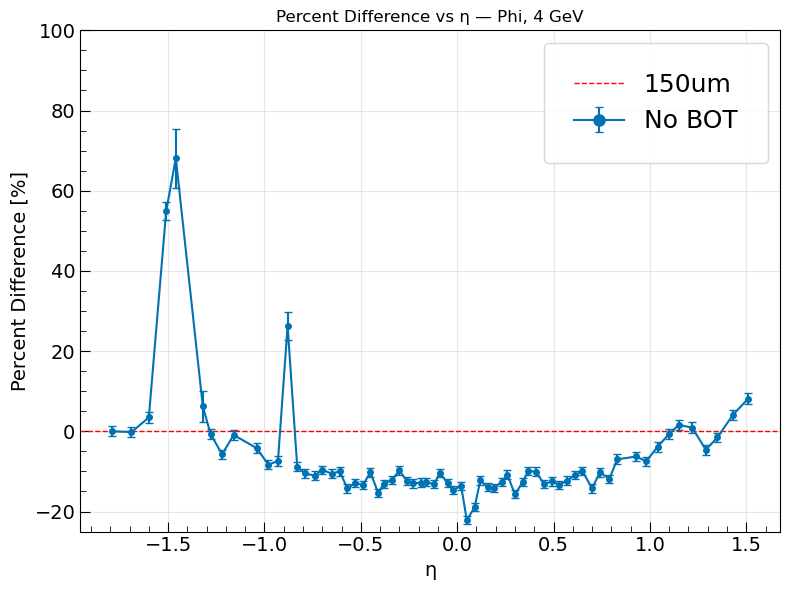

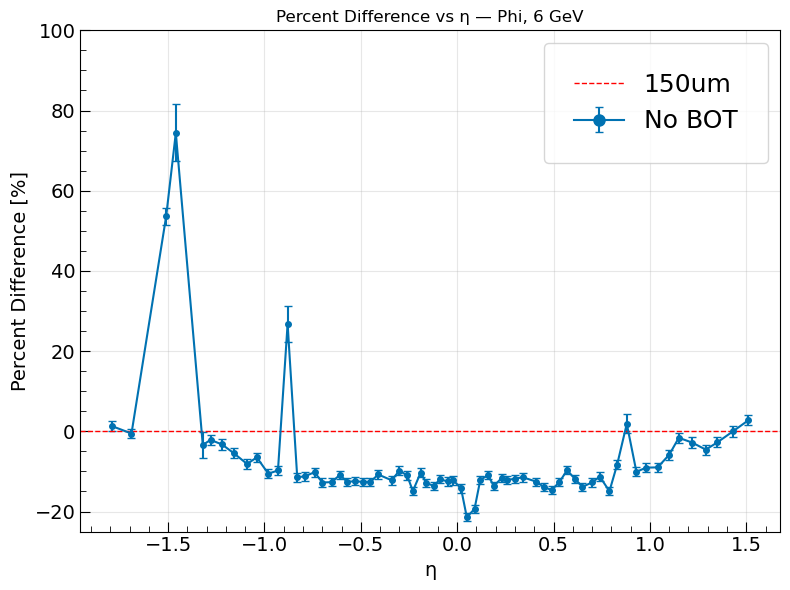

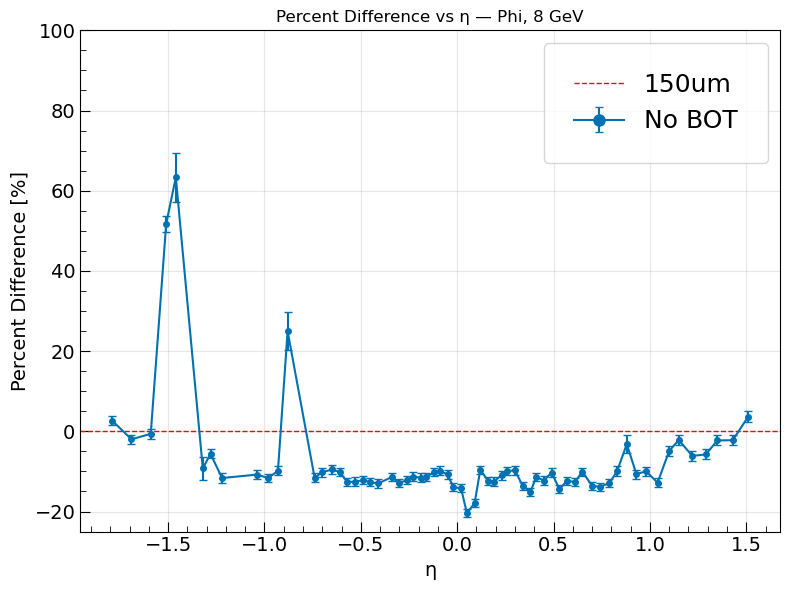

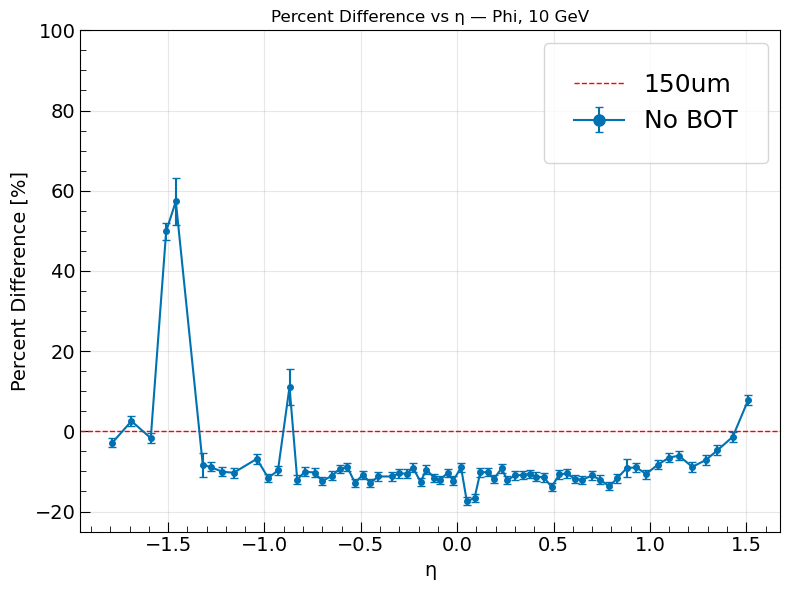

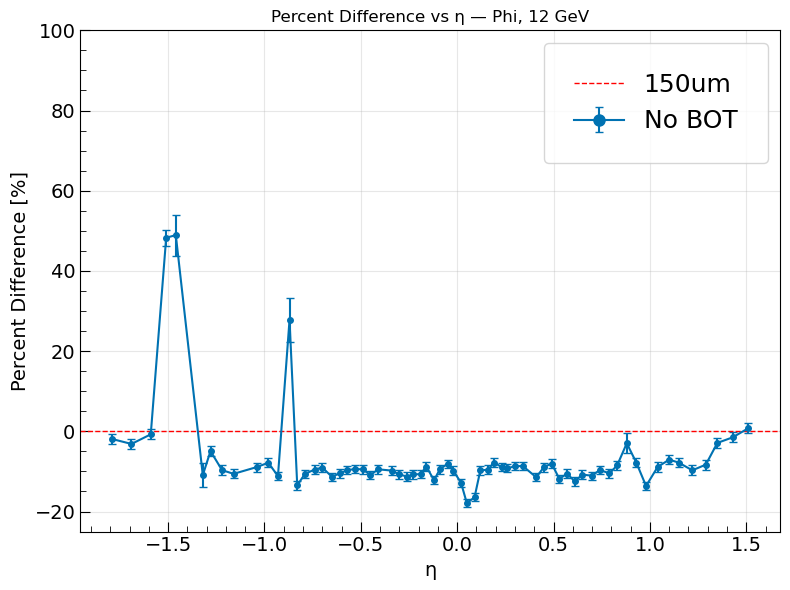

In [180]:
# --- Settings ---
baseline_setting = 'tracking_only'
#compare_settings = ['tracking_only_noBOT', 'tracking_only_100umBOT', 'tracking_only_70umBOT']
compare_settings = ['tracking_only_noBOT']

angles = ['Theta', 'Phi']
moms = sorted(df['momentum_GeV'].unique())

plt.style.use("seaborn-v0_8-colorblind")

# --- Loop over each angle (creates one PDF per angle) ---
for angle in angles:
    output_pdf = f"PercentDifference_{angle}_Comparisons.pdf"

    with PdfPages(output_pdf) as pdf:
        for mom in moms:
            plt.figure(figsize=(8,6))

            # Baseline subset
            base_df = df[(df['setting'] == baseline_setting) &
                         (df['angle'] == angle) &
                         (df['momentum_GeV'] == mom)].copy()

            # Remove invalid baseline entries
            base_df = base_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['sigma', 'sigma_err'])
            base_df = base_df[(base_df['sigma'] != 0) & (base_df['sigma_err']<2)& (base_df['eta']<1.8) & (base_df['eta']>-1.8)]

            for setting in compare_settings:
                comp_df = df[(df['setting'] == setting) &
                             (df['angle'] == angle) &
                             (df['momentum_GeV'] == mom)].copy()

                # Remove invalid comparison entries
                comp_df = comp_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['sigma', 'sigma_err'])
                comp_df = comp_df[(comp_df['sigma'] != 0) & (comp_df['sigma_err']<2)& (comp_df['eta']<1.8) & (comp_df['eta']>-1.8)]

                # Ensure both have matching η bins
                merged = pd.merge(base_df, comp_df, on='eta', suffixes=('_base', '_comp'))
                if merged.empty:
                    print(f"⚠️ No valid overlapping η bins for {setting}, {angle}, {mom} GeV")
                    continue

                # --- Compute percent difference safely ---
                percent_diff = 100 * (merged['sigma_comp'] - merged['sigma_base']) / merged['sigma_base']

                # --- Propagate uncertainty ---
                percent_diff_err = 100 * np.sqrt(
                    (merged['sigma_err_comp'] / merged['sigma_base'])**2 +
                    (merged['sigma_comp'] * merged['sigma_err_base'] / merged['sigma_base']**2)**2
                )
                match = re.search(r"\d+um", setting)
                if match:
                   label_setting = match.group(0)
                else:
                  print("No match found")
                  label_setting = "No BOT"
                print(label_setting)

                # --- Plot ---
                plt.errorbar(
                    merged['eta'], percent_diff,
                    yerr=percent_diff_err,
                    fmt='o-', capsize=3, markersize=4,
                    label=f"{label_setting}"
                )

            # --- Format plot ---
            plt.axhline(0, color='red', linestyle='--', linewidth=1, label="150um")
            plt.title(f"Percent Difference vs η — {angle}, {mom:.0f} GeV")
            plt.xlabel('η',fontsize=14)
            plt.ylabel('Percent Difference [%]',fontsize=14)
            plt.ylim(-25, 100)
            plt.grid(alpha=0.3)
            # Make x and y axis numbers larger
            plt.tick_params(axis='both', labelsize=14)
            #Optional: adjust minor tick appearance
            plt.minorticks_on()
            plt.tick_params(axis='both', which='minor', length=4, direction='in')
            plt.tick_params(axis='both', which='major', length=7, direction='in')

            plt.legend(
               title="",
               fontsize=18,          # legend label size
               title_fontsize=14,    # legend title size
               markerscale=2,      # (optional) make line/marker bigger
               borderpad=1.2         # (optional) expand legend box
            )
            plt.tight_layout()

            if(fSAVE == True):
            # --- Save each page ---
               pdf.savefig()
               plt.close()
               print(f"✅ Saved percent difference plots for {angle} into {output_pdf}")


No match found
tracking_only_noBOT
No match found
tracking_only_noBOT
No match found
tracking_only_noBOT
No match found
tracking_only_noBOT
No match found
tracking_only_noBOT
No match found
tracking_only_noBOT
No match found
tracking_only_noBOT
No match found
tracking_only_noBOT
No match found
tracking_only_noBOT
No match found
tracking_only_noBOT
No match found
tracking_only_noBOT
No match found
tracking_only_noBOT
No match found
tracking_only_noBOT
No match found
tracking_only_noBOT


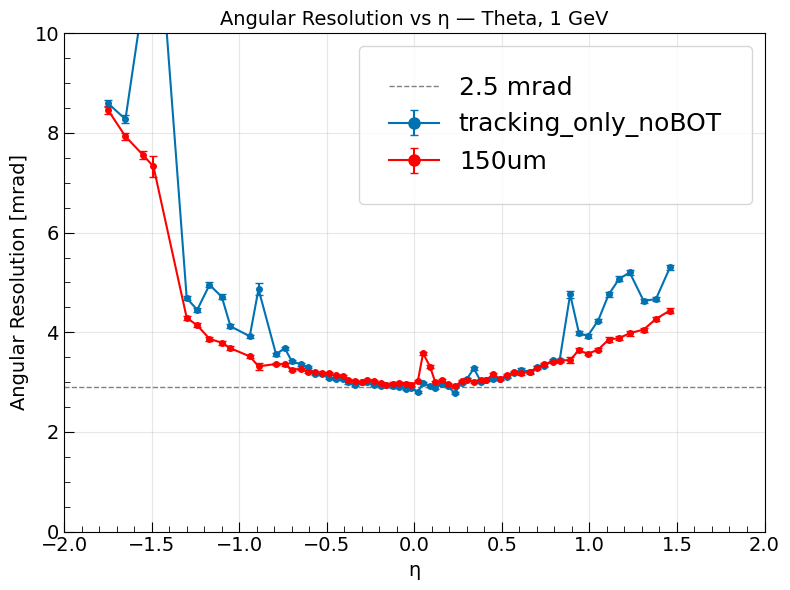

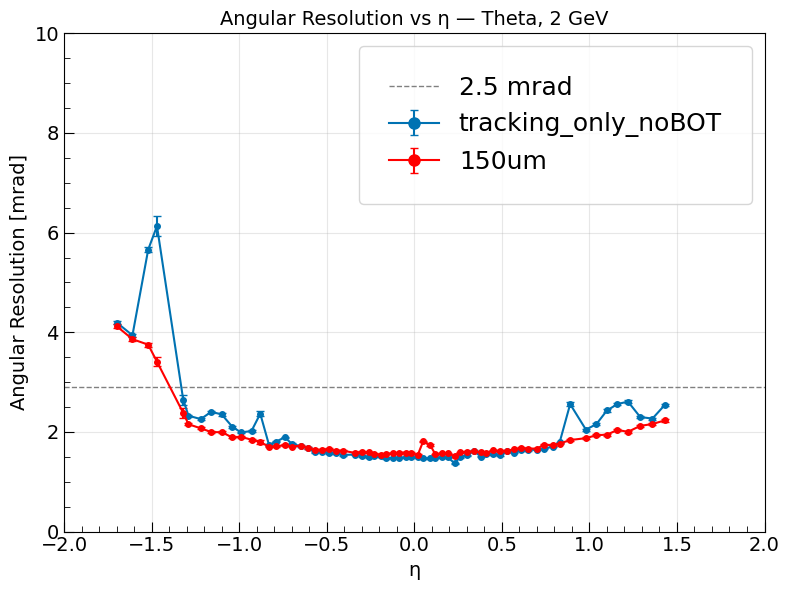

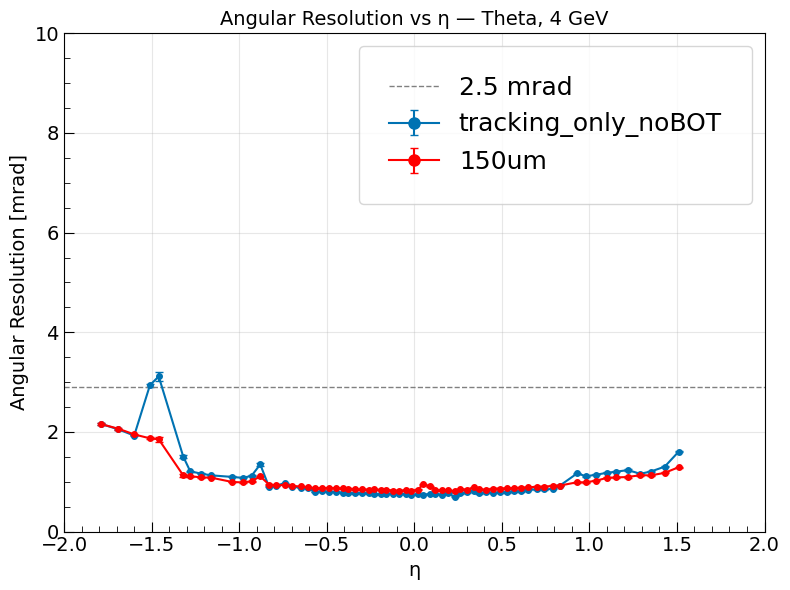

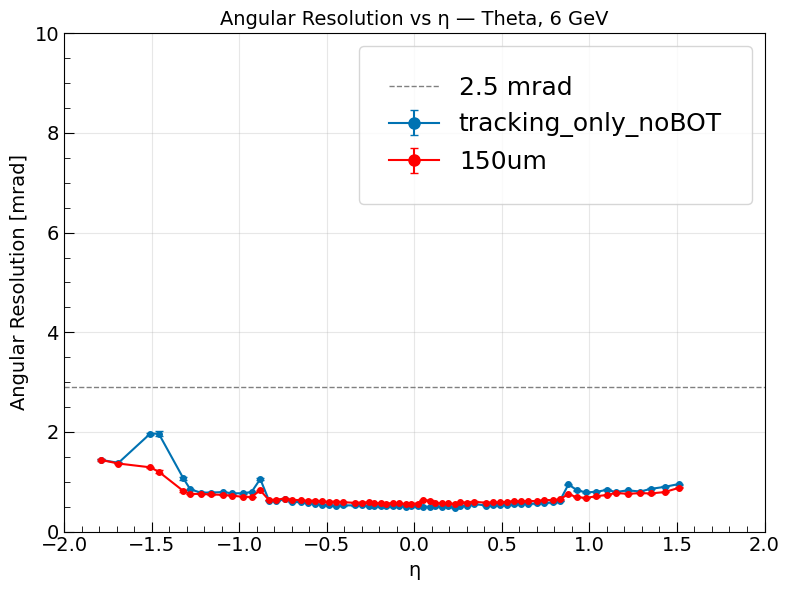

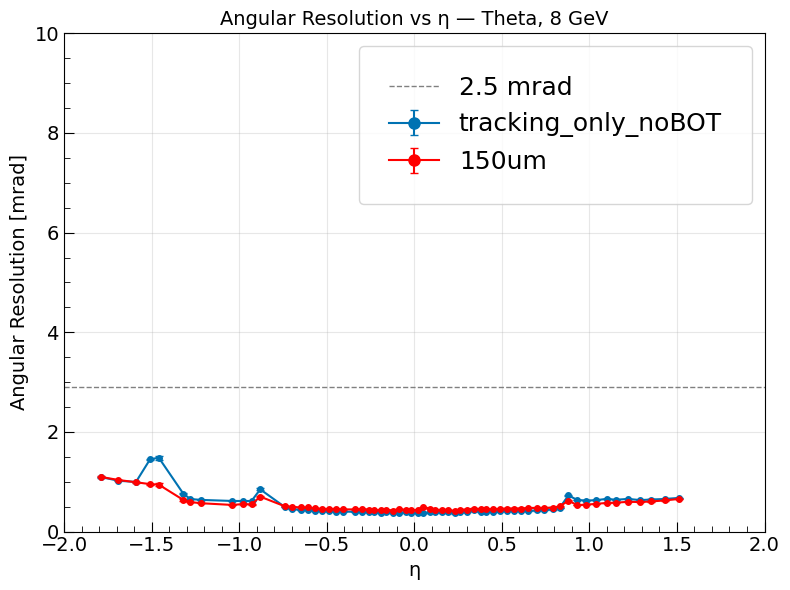

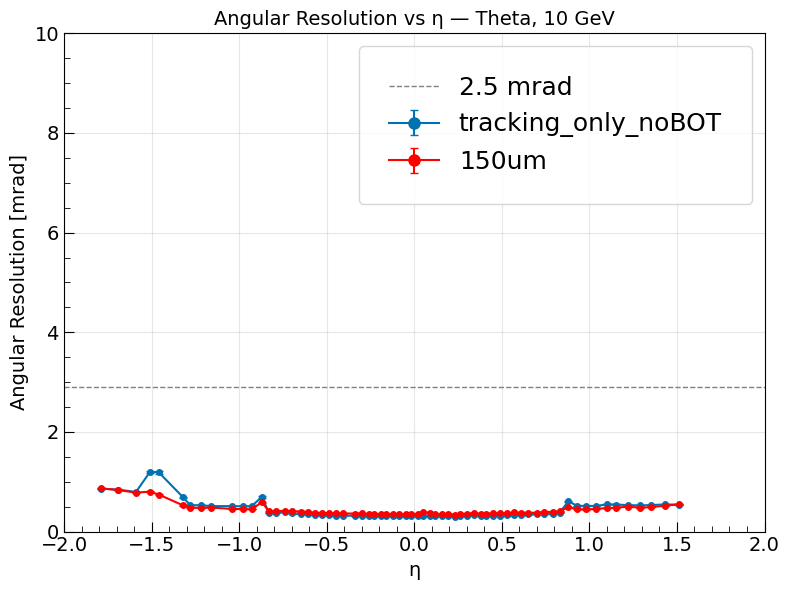

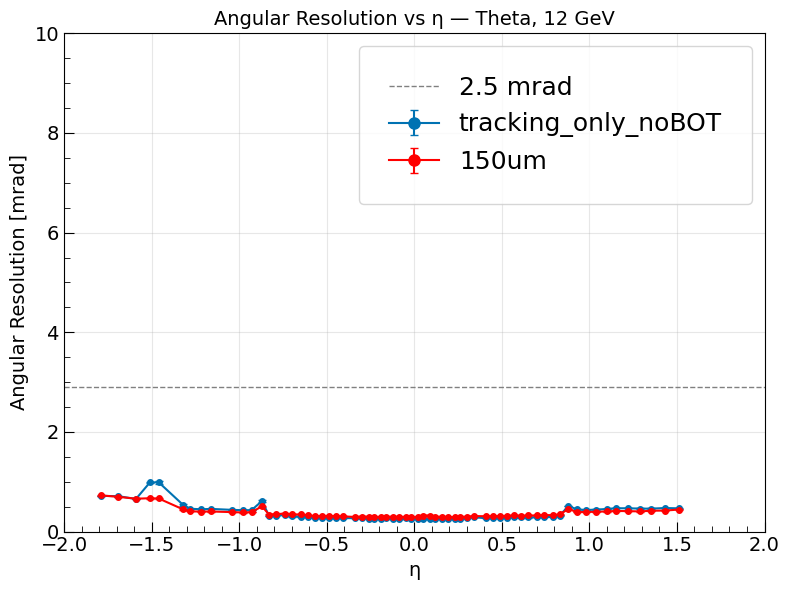

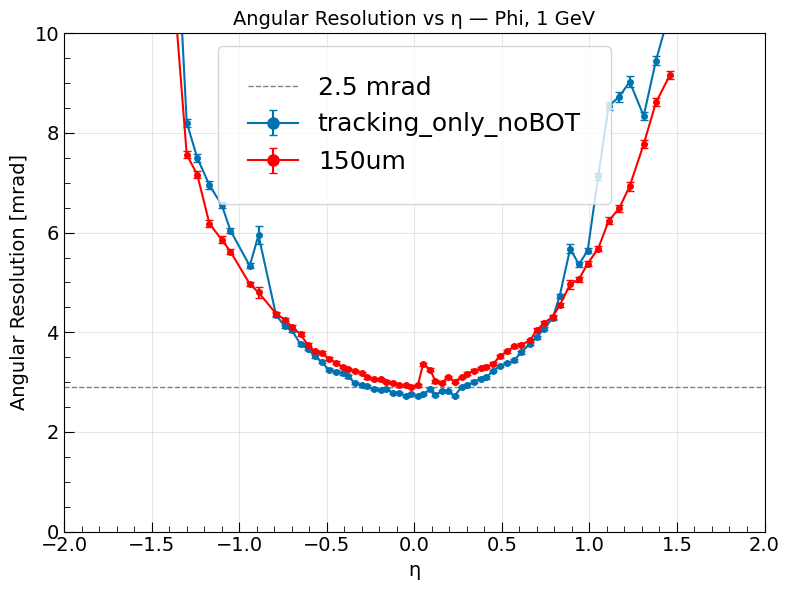

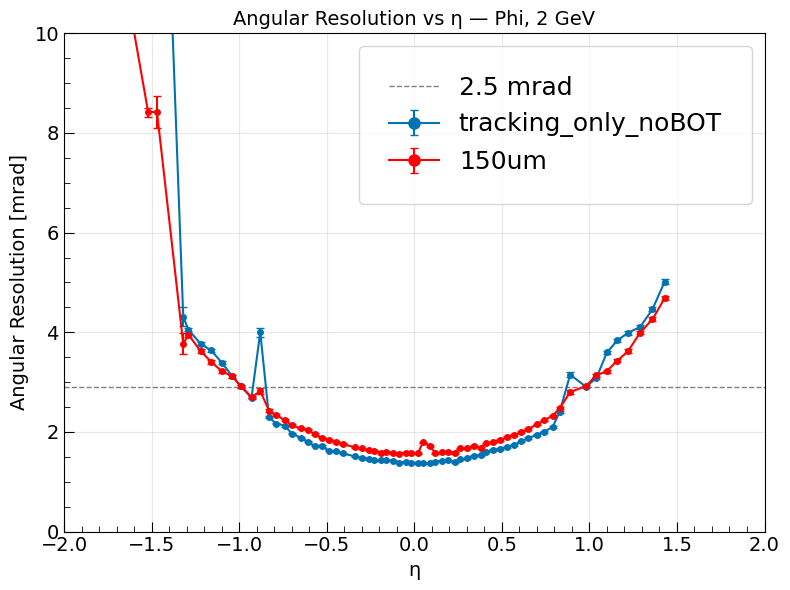

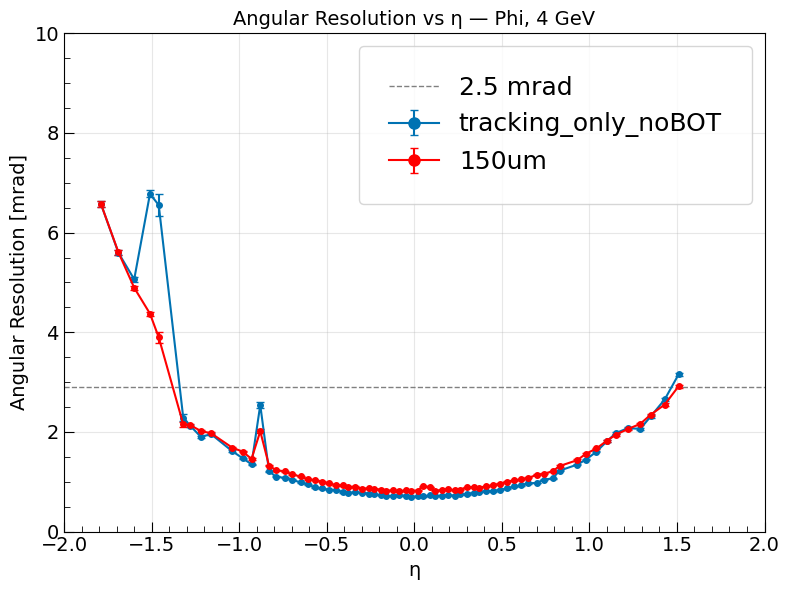

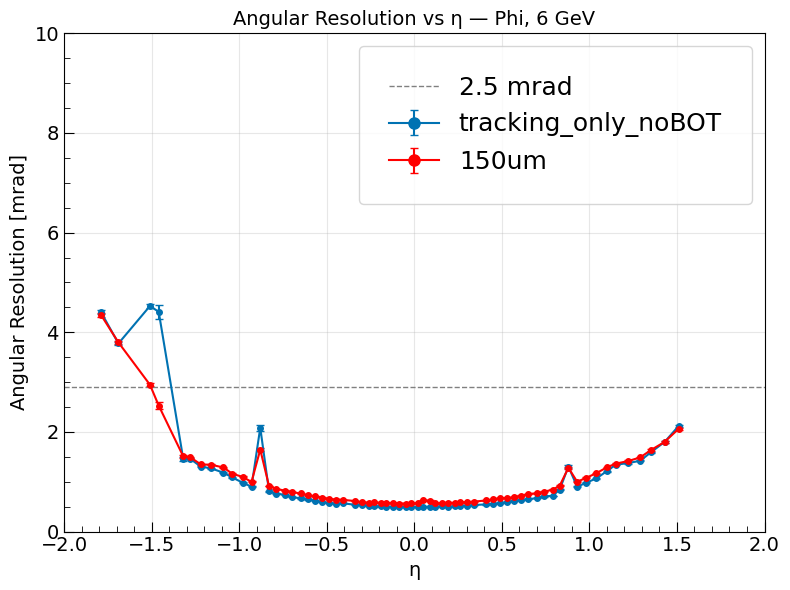

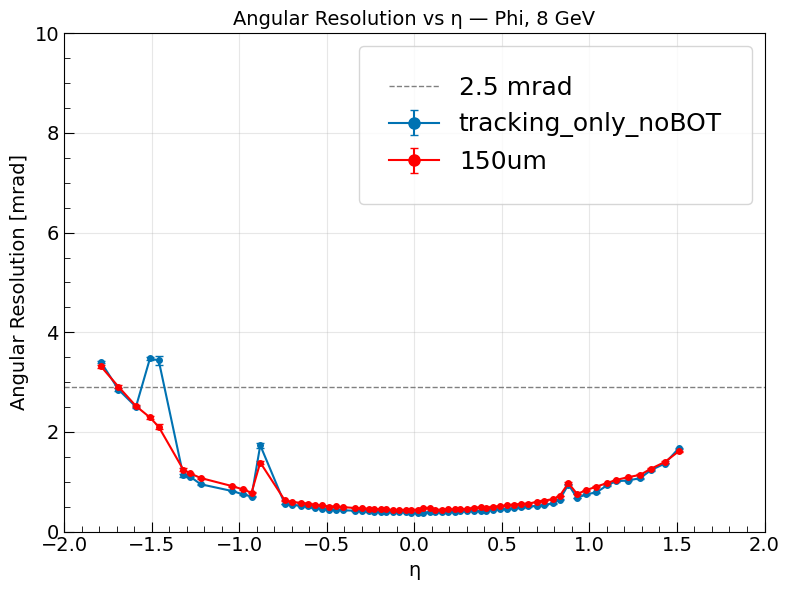

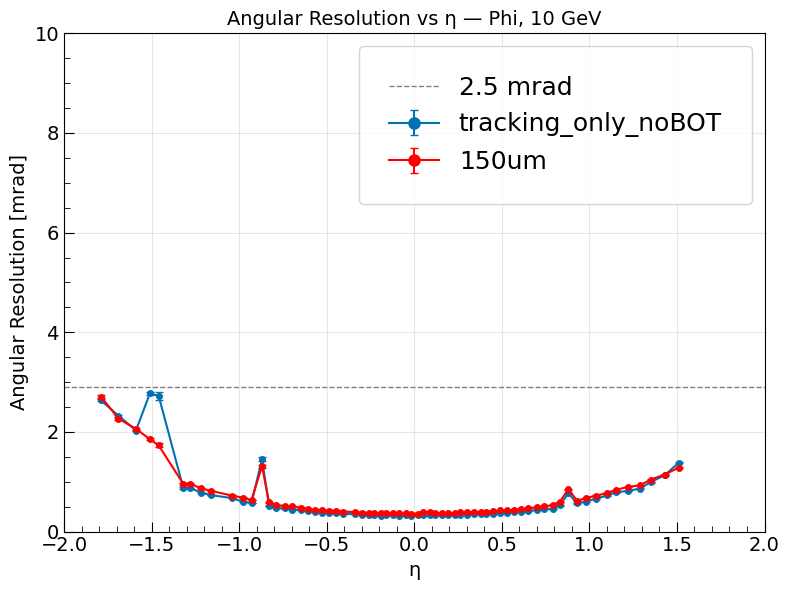

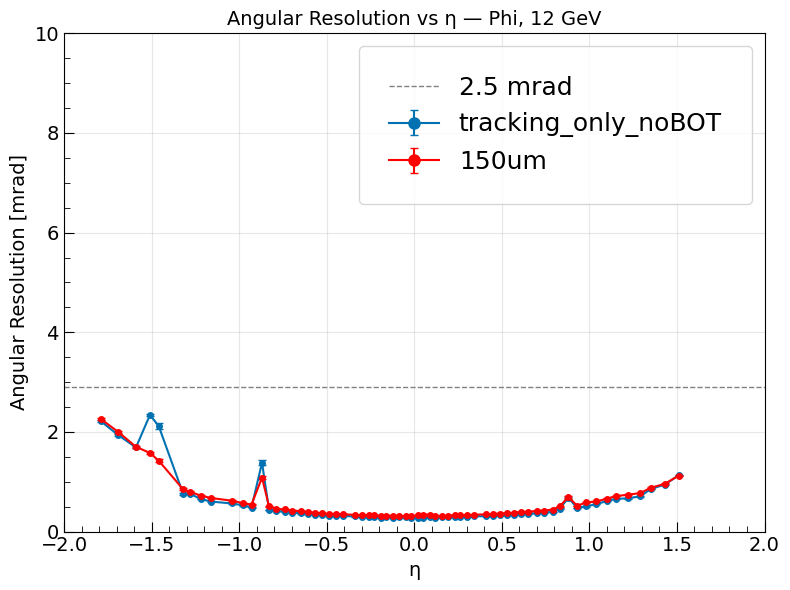

In [196]:
# --- Settings ---
baseline_setting = 'tracking_only'
#compare_settings = ['tracking_only_noBOT', 'tracking_only_100umBOT','tracking_only_70umBOT']
compare_settings = ['tracking_only_noBOT']

angles = ['Theta', 'Phi']
moms = sorted(df['momentum_GeV'].unique())

plt.style.use("seaborn-v0_8-colorblind")

# --- Loop over each angle (creates one PDF per angle) ---
for angle in angles:
    output_pdf = f"PercentDifference_{angle}_Comparisons.pdf"

    with PdfPages(output_pdf) as pdf:
        for mom in moms:
            plt.figure(figsize=(8,6))
            

            # Baseline subset
            base_df = df[(df['setting'] == baseline_setting) &
                         (df['angle'] == angle) &
                         (df['momentum_GeV'] == mom)].copy()

            # Remove invalid baseline entries
            base_df = base_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['sigma', 'sigma_err'])
            base_df = base_df[ (base_df['sigma'] != 0) & (base_df['sigma_err'] < 2) & (base_df['eta']<1.8) & (base_df['eta']>-1.8)]

            for setting in compare_settings:
                comp_df = df[(df['setting'] == setting) &
                             (df['angle'] == angle) &
                             (df['momentum_GeV'] == mom)].copy()

                # Remove invalid comparison entries
                comp_df = comp_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['sigma', 'sigma_err'])
                comp_df = comp_df[ (comp_df['sigma'] != 0) & (comp_df['sigma_err'] < 2) & (comp_df['eta']<1.8) & (comp_df['eta']>-1.8)]

                # Ensure both have matching η bins
                merged = pd.merge(base_df, comp_df, on='eta', suffixes=('_base', '_comp'))
                if merged.empty:
                    print(f"⚠️ No valid overlapping η bins for {setting}, {angle}, {mom} GeV")
                    continue

                # --- Compute percent difference safely ---
                value_base = merged['sigma_base']
                value_comp = merged['sigma_comp']
                
                # --- Propagate uncertainty ---
                value_base_err = merged['sigma_err_base'] 
                value_comp_err = merged['sigma_err_comp'] 
                
                match = re.search(r"\d+um", setting)
                if match:
                   label_setting = match.group(0)
                else:
                  print("No match found")
                  label_setting = setting
                print(label_setting)
                #label_setting = re.search(r"\d+um", setting).group()
                # --- Plot ---
                plt.errorbar(
                    merged['eta'], value_comp,
                    yerr=value_comp_err,
                    fmt='o-', capsize=3, markersize=4,
                    label=f"{label_setting}"
                )
            plt.errorbar(
                merged['eta'], value_base,
                yerr=value_base_err,
                fmt='o-', capsize=3, markersize=4,color='red',
                label=f"150um"
            )

            # --- Format plot ---
            plt.axhline(2.9, color='gray', linestyle='--', linewidth=1, label="2.5 mrad")
            plt.title(f"Angular Resolution vs η — {angle}, {mom:.0f} GeV",fontsize=14)
            plt.xlabel('η', fontsize=14)                 # Increase x-label size
            plt.ylabel('Angular Resolution [mrad]', fontsize=14)   # Increase y-label size
            plt.ylim(0.0, 10)
            plt.xlim(-2,2)
            plt.grid(alpha=0.3)
            # Make x and y axis numbers larger
            plt.tick_params(axis='both', labelsize=14)
            #Optional: adjust minor tick appearance
            plt.minorticks_on()
            plt.tick_params(axis='both', which='minor', length=4, direction='in')
            plt.tick_params(axis='both', which='major', length=7, direction='in')

            plt.legend(
               title="",
               fontsize=18,          # legend label size
               title_fontsize=14,    # legend title size
               markerscale=2,      # (optional) make line/marker bigger
               borderpad=1.2         # (optional) expand legend box
            )
            plt.tight_layout()

            if(fSAVE == True):
            # --- Save each page ---
               pdf.savefig()
               plt.close()
               print(f"✅ Saved percent difference plots for {angle} into {output_pdf}")
